In [1]:
import string

import pandas as pd
import numpy as np
import nltk
#nltk.download()
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.datasets import load_iris

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

In [2]:
pd.set_option('display.max_colwidth', None)

In [3]:
stop_words = set(stopwords.words('spanish'))

In [4]:
def tokenizer(text):
    tt = TweetTokenizer()
    return tt.tokenize(text)

### Loading labeled tweets

In [5]:
# Dataset loaded from: https://docs.google.com/spreadsheets/d/11_E2ngsEOyTQwbwVVRHY5urzFF95BQCV/edit#gid=1788161364
tweets_df = pd.read_csv('./data/tweets.csv', sep = ',')

In [6]:
tweets_df.shape

(889, 3)

In [7]:
tweets_df.head()

,full_text,sentiment,emotion
0,"@IvanDuque Sus socios de las AGC tienen este platanal vuelto mierda, pero no haces nada, usted inservible, ha logrado la peor inflación en Colombia y solo pública maricadas sin sentido, se robó las elecciones para entregar el país, valiente idiota tenemos de presidente.",negative,anger
1,@AlvaroUribeVel Ellos también celebran por que Maduro PetroGustavo Ivan Cepeda Timo Teodora Bobolivar entre muchos más sufren de insomnio.\nUribe Velez Alvarito no los deja dormir\nEl enemigo para las elecciones no es Fico.... Sino el Excelentísimo y más Grande Presidente que ha tenido Colombia,negative,anger
2,"@PDleh @cokycafe @PGN_COL En Colombia existen miles de leyes para controlar los funcionarios públicos pero a la hora de aplicarlas ""se les olvida que existen"". ¿Que más pruebas quieren? ¿Porque avalan unas elecciones, las del 13 de marzo, donde pado de todo lo que no debía de pasar? Escuchamos respuestas",negative,anger
3,Petro ahora es el Capitán América o mejor dicho el Capitán Colombia de ganar las elecciones. No soltara el escudo ni para dormir 😂 https://t.co/k56Dv7id1J,negative,joy
4,"#OtraPregunta \n""Petro promete reanudar relaciones diplomáticas con Maduro si gana elecciones en Colombia""...\nEsto no pinta nada bien... y si además gana Lula en Brasil...\n¿Esto como que va para largo? https://t.co/wpQsl5KoRe",positive,fear


In [8]:
tweets_df['sentiment'].value_counts(dropna = False, normalize = True)

negative    0.462317
NaN         0.294713
neutral     0.194601
positive    0.048369
Name: sentiment, dtype: float64

In [9]:
tweets_df['emotion'].value_counts(dropna = False, normalize = True)

NaN        0.595051
anger      0.195726
joy        0.098988
fear       0.076490
sadness    0.033746
Name: emotion, dtype: float64

### Leaving out unlabeled texts, this data is not useful for training or validating a supervised model

In [10]:
# Removing  unlabeled tweets
tweets_labeled_df = tweets_df.loc[tweets_df['sentiment'].notnull()]

In [11]:
tweets_labeled_df.shape

(627, 3)

In [12]:
tweets_unlabeled_df = tweets_df.loc[tweets_df['sentiment'].isnull()]

In [13]:
tweets_unlabeled_df.shape

(262, 3)

In [14]:
# Scenario 1: Working with all classes

# Scenario 2: Working only with positive and negative classes
# Removing neutral class
#tweets_labeled_df = tweets_labeled_df.loc[tweets_labeled_df['sentiment'].isin(['positive', 'negative'])]

# Scenario 3: Treating neutral as positive classes
tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})

C:\Users\edins\AppData\Local\Temp\ipykernel_12248\778818246.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweets_labeled_df['sentiment'] = tweets_labeled_df['sentiment'].replace({'neutral': 'positive'})


### Splitting train and test datasets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(tweets_labeled_df['full_text'], tweets_labeled_df['sentiment'], test_size = 0.2, stratify = tweets_labeled_df['sentiment'], random_state = 1)

In [16]:
X_train.shape

(501,)

In [17]:
pd.Series(y_train).value_counts(normalize = True)

negative    0.654691
positive    0.345309
Name: sentiment, dtype: float64

In [18]:
X_test.shape

(126,)

In [19]:
pd.Series(y_test).value_counts(normalize = True)

negative    0.65873
positive    0.34127
Name: sentiment, dtype: float64

In [20]:
bow = CountVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [21]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words)

In [22]:
X_bow = bow.fit_transform(X_train)

In [23]:
X_tfidf = tfidf.fit_transform(X_train)

### Training and evaluating a model using BOW

In [24]:
#model_SVM = make_pipeline(StandardScaler(), SVC(kernel='poly', degree=2, gamma='scale'))
model_SVM = SVC(kernel='poly', degree=2, gamma='scale')

In [25]:
model_SVM.fit(X_bow, y_train)

SVC(degree=2, kernel='poly')

In [26]:
y_train_bow_predict = model_SVM.predict(X_bow)
y_test_bow_predict = model_SVM.predict(bow.transform(X_test))

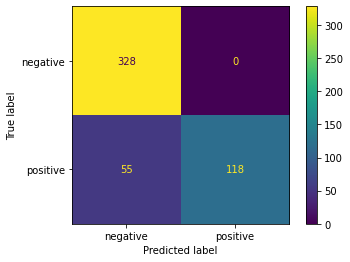

In [27]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

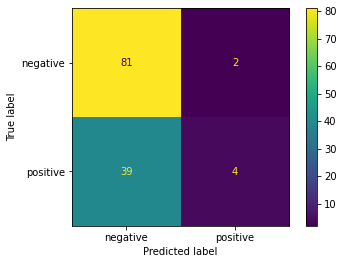

In [28]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [29]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_bow_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_bow_predict, pos_label = 'positive'))

Precision: 0.6666666666666666
Recall: 0.09302325581395349
F1: 0.16326530612244897


In [30]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_bow_predict, average = None))
print('Recall:', recall_score(y_test, y_test_bow_predict, average = None))
print('F1:', f1_score(y_test, y_test_bow_predict, average = None))

Precision: [0.675      0.66666667]
Recall: [0.97590361 0.09302326]
F1: [0.79802956 0.16326531]


### Training and evaluating a model using TF-IDF

In [31]:
model_SVM = SVC(kernel='poly', degree=2, gamma='scale')

In [32]:
model_SVM.fit(X_tfidf, y_train)

SVC(degree=2, kernel='poly')

In [33]:
y_train_tfidf_predict = model_SVM.predict(X_tfidf)
y_test_tfidf_predict = model_SVM.predict(bow.transform(X_test))

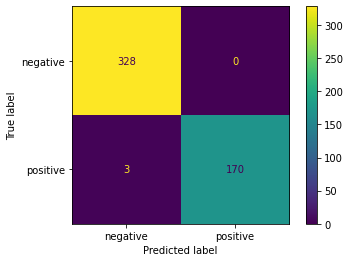

In [34]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

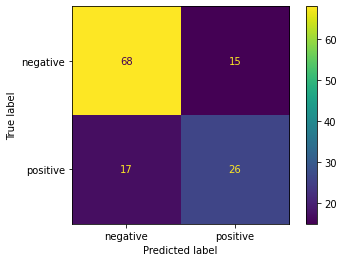

In [35]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [36]:
# Metrics calculation for binary classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))
print('F1:', f1_score(y_test, y_test_tfidf_predict, pos_label = 'positive'))

Precision: 0.6341463414634146
Recall: 0.6046511627906976
F1: 0.6190476190476191


In [37]:
# Metrics calculation for more than two classes
print('Precision:', precision_score(y_test, y_test_tfidf_predict, average = None))
print('Recall:', recall_score(y_test, y_test_tfidf_predict, average = None))
print('F1:', f1_score(y_test, y_test_tfidf_predict, average = None))

Precision: [0.8        0.63414634]
Recall: [0.81927711 0.60465116]
F1: [0.80952381 0.61904762]


### Analyzing errors

In [38]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test ], axis = 1).reset_index(),
    pd.Series(y_test_bow_predict) ]
, axis = 1).rename(columns = { 'sentiment': 'actual', 0: 'predicted' })

error_df.drop('index', inplace = True, axis = 1)

In [39]:
error_df.shape

(126, 3)

In [40]:
error_df.loc[error_df['actual'] != error_df['predicted']].head(100)

,full_text,actual,predicted
1,EL órgano de control evaluará los hechos para garantizar la idoneidad de los jurados de votación y lograr unas Elecciones Transparentes.👇\n\nhttps://t.co/jWAc4byuUL,positive,negative
8,Hoy amanece colombia secuestrada y sitiada por los amigos de un candidato que lleva las politicas de un expresidente durante los ultimos años y tiene a un pais en jaque!\nTenemos la posibilidad de salvar a colombia en estas elecciones 2022.\nTenemos el derecho al cambio y a la paz https://t.co/gf6MHsLrkc,positive,negative
9,#ColombiaDecide | Fajardo les respondió a quienes le piden un encuentro con Gustavo Petro https://t.co/5IhrL6apo4,positive,negative
12,@CARLOSFMEJIA @infopresidencia @PGN_COL @FiscaliaCol @CNE_COLOMBIA Así es.\nEs lo correcto.\nHacer bien las elecciones.\nEsa es democracia.,positive,negative
21,"@CARLOSFMEJIA @marwhite01 @infopresidencia @PGN_COL @FiscaliaCol @CNE_COLOMBIA Exigimos se suspenda elecciones para primera vuelta, hasta no se esclarecer como ocurrió el MEGA-FRAUDE en las elecciones a senado y cámara donde 300.000 jurados,CNE y el registrador TIBISAY VEGA le validaron por arte de magia 1.500.000 votos al PACTO DE LA PICOTA @petrogustavo",positive,negative
22,@Lucho_Matto @JulianFMartinez @IvanDuque @DNP_Colombia que van a retener cedulas de trabajadores hasta despues de las elecciones. Suplantacion de identidad.\nPropongo: ordenar a Los jurados que tienen que preguntar al votante la fecha de nacimiento y numero de cedula.\nsi no se la saben toca ver si son los dueños reales de esa cedula.,positive,negative
27,@CARLOSFMEJIA @infopresidencia @FiscaliaCol @PGN_COL @CNE_COLOMBIA Las elecciones a @SenadoGovCo SE DEBER REPETIR…,positive,negative
31,Alertan que miles de jurados de votación están inhabilitados para estar en las elecciones a Presidente https://t.co/U0B0pSdoT0\nvia SQUID App https://t.co/HbtsGbArmc,positive,negative
35,"https://t.co/KXwMVRujE7 recomendado, votemos a conciencia. Este app que saco @elespectador le ayuda a ver como sus posiciones se alinean con su candidato. 1/3 #eleccionescolombia2022 #elecciones #colombia",positive,negative
40,"#ElRiesgoEs perder la senda de crecimiento por la que va Colombia después de elecciones. El FMI, el Banco de la República y el Banco Mundial proyectan que nuestra economía sea una de las que más crezca en la región este año. Hay que cuidar la inversión y la productividad del pais",positive,negative
